## AMNE 376: A Study of Richter's Kouroi Through Image Embedding

Author: *Kaiyan Zhang, Yash Mali, prAxIs UBC Team*

Before you start, make sure you have the required libraries installed, if not, uncomment by `ctrl` + `/` and run the following lines:

In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install opencv-python
# !pip install sklearn
# !pip install torch
# !pip install torchvision
# !pip install transformers
# !pip install datasets
# !pip install grad-cam

### 1. Introduction: How Computers See Visual Art?

#### 1.1 Digital Representations of Images

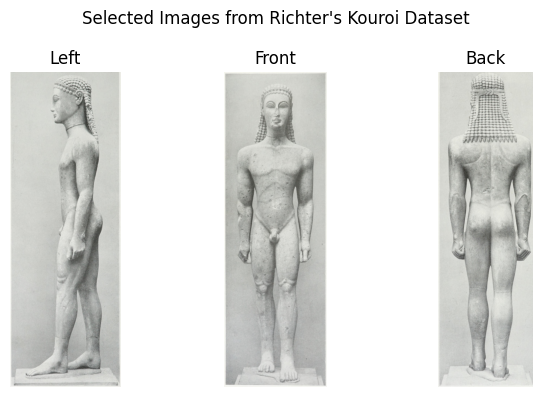

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the folder path where the images are stored
image_path = '../data/richter_kouroi_filtered_photos' 

fig, axes = plt.subplots(1, 3, figsize=(7, 4))

# List of specific image filenames
image_names = {'page188_img01_photo12.jpg': "Left", 'page188_img01_photo13.jpg': "Front", 'page189_img01_photo3.jpg': "Back"}

# Display the images side by side
axes = axes.flatten()
for i, img_name in enumerate(image_names):
    img_path = f"{image_path}/{img_name}"
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].set_title(image_names[img_name])
    axes[i].axis('off')

plt.suptitle("Selected Images from Richter's Kouroi Dataset")
plt.tight_layout()
plt.show()


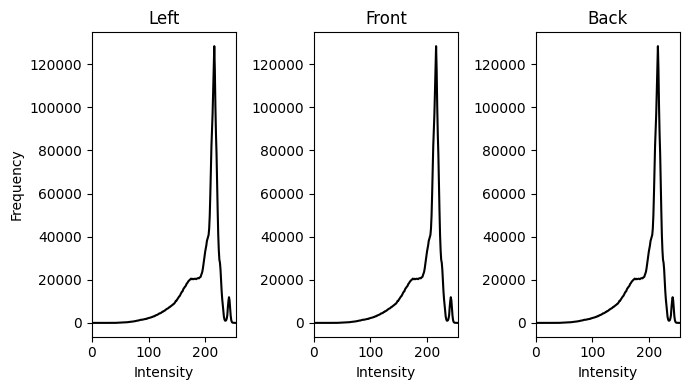

In [3]:
# Generate and plot greyscale histograms for the selected images
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

for i, img_name in enumerate(image_names):
    img_path = f"{image_path}/{img_name}"
    histogram = image.histogram()

    axes[i].plot(histogram, color='black')
    axes[i].set_title(f'{image_names[img_name]}')
    axes[i].set_xlim([0, 255])
    axes[i].set_xlabel("Intensity")
    if i == 0:
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

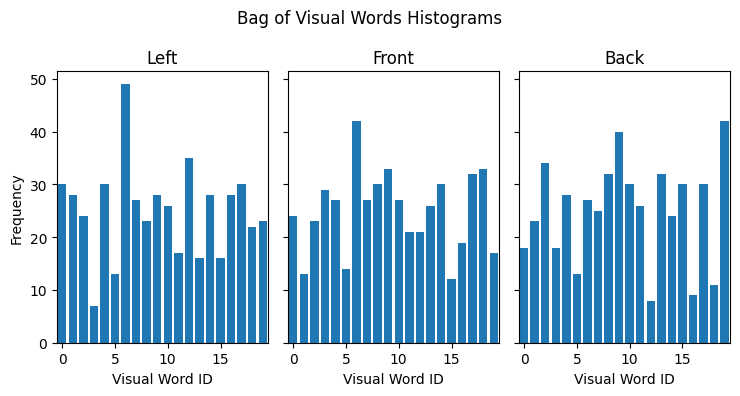

In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Define the number of clusters for KMeans
n_clusters = 20

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=500)
all_descriptors = []
image_data = []

for img_name in image_names:
    img_path = os.path.join(image_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = orb.detectAndCompute(img, None)

    all_descriptors.append(descriptors)
    
    image_data.append((img_name, descriptors))

# Stack descriptors for clustering
all_descriptors_stacked = np.vstack(all_descriptors)

# Build the visual vocabulary using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors_stacked)

# Compute histogram for each image
histograms = []
for img_name, descriptors in image_data:
    if descriptors.shape[0] > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(n_clusters+1))
    else:
        hist = np.zeros(n_clusters, dtype=int)
        
    histograms.append((img_name, hist))
    
fig, axes = plt.subplots(1, len(histograms), figsize=(2.5 * len(histograms), 4), sharey=True)
if len(histograms) == 1:
    axes = [axes]

x = np.arange(n_clusters)
for ax, (img_name, hist) in zip(axes, histograms):
    ax.bar(x, hist)
    ax.set_title(f"{image_names[img_name]}")
    ax.set_xlabel("Visual Word ID")
    ax.set_xlim([-0.5, n_clusters - 0.5])
    if ax is axes[0]:
        ax.set_ylabel("Frequency")

plt.suptitle("Bag of Visual Words Histograms")
plt.tight_layout()
plt.show()

#### 1.2 Measurement of Similarity

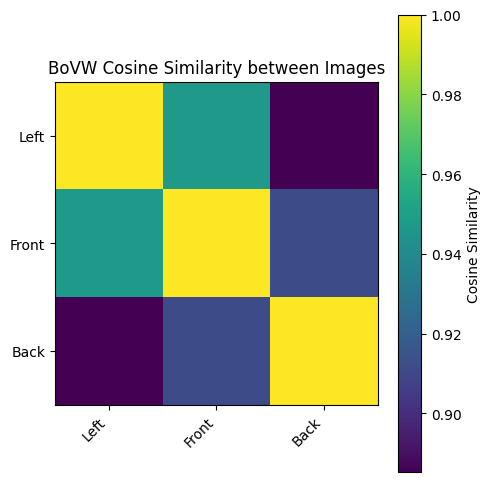

Pairwise Cosine Similarity Matrix:
Left vs Front: 0.947
Left vs Back: 0.885
Front vs Back: 0.912


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

hist_list = []
for img_name, descriptors in image_data:
    if descriptors.shape[0] > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(n_clusters + 1))
    else:
        hist = np.zeros(n_clusters, dtype=int)
    hist = hist.astype(float)
    if hist.sum() > 0:
        hist /= hist.sum()
    hist_list.append(hist)
    
histograms = np.array(hist_list)

sim_matrix = cosine_similarity(histograms)

image_keys = list(image_names.keys())
image_labels = list(image_names.values())

# Display the similarity matrix
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(sim_matrix, interpolation='nearest', cmap='viridis')
ax.set_title('BoVW Cosine Similarity between Images')
ax.set_xticks(np.arange(len(image_labels)))
ax.set_yticks(np.arange(len(image_labels)))
ax.set_xticklabels(image_labels, rotation=45, ha='right')
ax.set_yticklabels(image_labels)
fig.colorbar(cax, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

print("Pairwise Cosine Similarity Matrix:")
for i in range(len(image_labels)):
    for j in range(i + 1, len(image_labels)):
        print(f"{image_labels[i]} vs {image_labels[j]}: {sim_matrix[i, j]:.3f}")


Cosine Similarity of 'A Kouroi from Athens' with existing images:
Left vs A Kouroi from Athens: 0.816
Front vs A Kouroi from Athens: 0.892
Back vs A Kouroi from Athens: 0.839


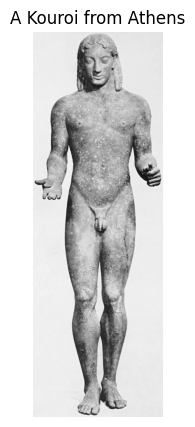

In [6]:
# Define a new image to compare with the existing ones
new_image_path = '../data/richter_kouroi_filtered_photos/page312_img01_photo4.jpg'
new_image_label = 'A Kouroi from Athens' # Suppose this is a new artifact we just discovered

img_new = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(nfeatures=500)
kp_new, desc_new = orb.detectAndCompute(img_new, None)

if desc_new is not None and len(desc_new) > 0:
    words_new = kmeans.predict(desc_new)
    hist_new, _ = np.histogram(words_new, bins=np.arange(kmeans.n_clusters + 1))
else:
    hist_new = np.zeros(kmeans.n_clusters, dtype=int)
    
hist_new = hist_new.astype(float)
if hist_new.sum() > 0:
    hist_new /= hist_new.sum()

sims = cosine_similarity(histograms, hist_new.reshape(1, -1)).flatten() 

# Print the cosine similarity of the new image with existing images
print(f"\nCosine Similarity of '{new_image_label}' with existing images:")
for i, label in enumerate(image_labels):
    print(f"{label} vs {new_image_label}: {sims[i]:.3f}")

# Show the new image
plt.figure(figsize=(5, 5))
plt.imshow(img_new, cmap='gray')
plt.title(f"{new_image_label}")
plt.axis('off')
plt.show()



Cosine Similarity of 'A Bronze Figure from Sanxingdui' with existing images:
Left vs A Bronze Figure from Sanxingdui: 0.586
Front vs A Bronze Figure from Sanxingdui: 0.640
Back vs A Bronze Figure from Sanxingdui: 0.638


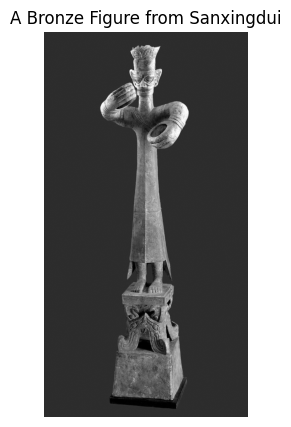

In [7]:
# Define a new image to compare with the existing ones
new_image_path2 = '../data/example_images/sanxingdui.jpeg'
new_image_label2 = 'A Bronze Figure from Sanxingdui' # Suppose this is a new artifact we just discovered

img_new2 = cv2.imread(new_image_path2, cv2.IMREAD_GRAYSCALE)
orb = cv2.ORB_create(nfeatures=500)
kp_new, desc_new = orb.detectAndCompute(img_new2, None)

if desc_new is not None and len(desc_new) > 0:
    words_new = kmeans.predict(desc_new)
    hist_new, _ = np.histogram(words_new, bins=np.arange(kmeans.n_clusters + 1))
else:
    hist_new = np.zeros(kmeans.n_clusters, dtype=int)
    
hist_new = hist_new.astype(float)
if hist_new.sum() > 0:
    hist_new /= hist_new.sum()

sims = cosine_similarity(histograms, hist_new.reshape(1, -1)).flatten()  

# Print the cosine similarity of the new image with existing images
print(f"\nCosine Similarity of '{new_image_label2}' with existing images:")
for i, label in enumerate(image_labels):
    print(f"{label} vs {new_image_label2}: {sims[i]:.3f}")

# Show the new image
plt.figure(figsize=(5, 5))
plt.imshow(img_new2, cmap='gray')
plt.title(f"{new_image_label2}")
plt.axis('off')
plt.show()

### 2. Data Exploration

#### 2.1 Exploring the Metadata

In [8]:
import pandas as pd

# Read in the metadata CSV file
# Note that we are only going to investigate a subset of the full dataset
df = pd.read_csv('../data/complete_sculpture_dataset_labeled.csv')

df = df.drop(columns = 'page')

print(df.head())

                    filename          group           era material
0  page188_img01_photo13.jpg  SOUNION GROUP  615 - 590 BC   Marble
1   page202_img01_photo3.jpg  SOUNION GROUP  615 - 590 BC   Marble
2   page202_img01_photo4.jpg  SOUNION GROUP  615 - 590 BC   Marble
3   page205_img01_photo4.jpg  SOUNION GROUP  615 - 590 BC   Marble
4  page211_img01_photo12.jpg  SOUNION GROUP  615 - 590 BC     Lead


In [9]:
print("Information of the dataset:")
print(f"Number of images: {df.shape[0]}")
print(f"Number of distinct eras: {df['era'].nunique()}")
print(f"Number of distinct materials: {df['material'].nunique()}")

Information of the dataset:
Number of images: 62
Number of distinct eras: 7
Number of distinct materials: 6


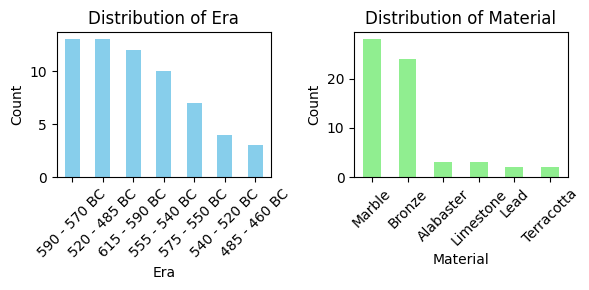

In [10]:
def bar_plot(df, column1, column2):
    # Calculate counts of each value in the specified columns
    label_counts1 = df[column1].value_counts()
    label_counts2 = df[column2].value_counts()

    # Create a figure with a fixed size
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Plot the bar chart
    label_counts1.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {column1.capitalize()}')
    axes[0].set_xlabel(column1.capitalize())
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    label_counts2.plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Distribution of {column2.capitalize()}')
    axes[1].set_xlabel(column2.capitalize())
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot the distribution of labels in the dataset
bar_plot(df, 'era', 'material')

#### 2.2 Exploring the Images

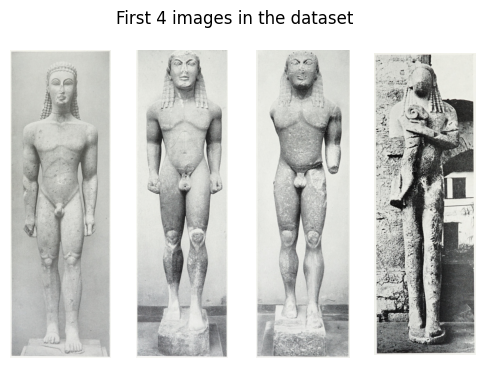

In [11]:
# Read in the images as a list 
from pathlib import Path

data_dir = Path("../data/richter_kouroi_complete_front_only")
image_paths = sorted(data_dir.glob("*.jpg"))

images = []
for p in image_paths:
    img = Image.open(p).convert("RGB")   # ensure 3‑channel
    img_arr = np.array(img)
    images.append(img_arr)
    
fig, axes = plt.subplots(1, 4, figsize=(6, 4))
for ax, img in zip(axes, images[:4]):
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("First 4 images in the dataset")
plt.show()

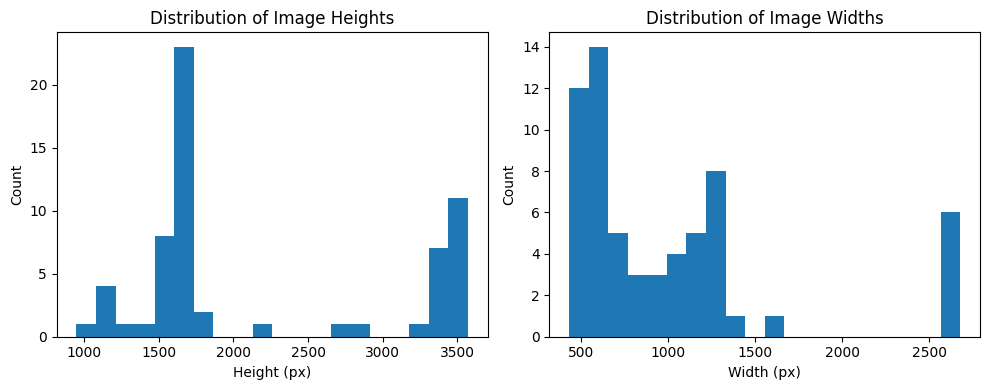

Mean Height: 2177.35 px
Mean Width: 999.10 px


In [12]:
shapes = [img.shape for img in images]
dtypes = set(img.dtype for img in images)

# Histogram of image heights and widths
heights = [s[0] for s in shapes]
widths  = [s[1] for s in shapes]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(heights, bins=20)
ax[0].set_title("Distribution of Image Heights")
ax[0].set_xlabel("Height (px)")
ax[0].set_ylabel("Count")
ax[1].hist(widths, bins=20)
ax[1].set_title("Distribution of Image Widths")
ax[1].set_xlabel("Width (px)")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

mean_height = np.mean(heights)
mean_width = np.mean(widths)
print(f"Mean Height: {mean_height:.2f} px")
print(f"Mean Width: {mean_width:.2f} px")

### 3. Convolutions on Images


**What are convolutions?**

Image sliding a tiny image over an actual image. A convolutions does exactly that and performs a mathematical operation that makes the actual image look like the tiny image.

Below is a tiny image:


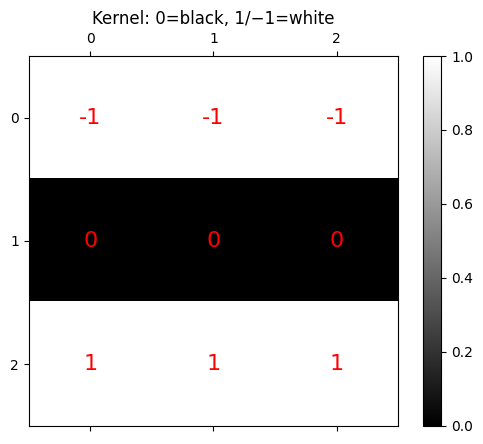

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Kernel
kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

# Map: 1 -> 1.0 (white), 0 -> 0.0 (black), -1 -> 1.0 (white)
display_kernel = np.where(kernel == 0, 0.0, 1.0)

fig, ax = plt.subplots()
cax = ax.matshow(display_kernel, cmap='gray', vmin=0, vmax=1)
plt.colorbar(cax)
# Annotate the kernel values
for (i, j), val in np.ndenumerate(kernel):
    ax.text(j, i, str(val), ha='center', va='center', color='red', fontsize=16)
ax.set_title('Kernel: 0=black, 1/−1=white')
plt.show()

This is an actual image **Convolved** with the tiny image:

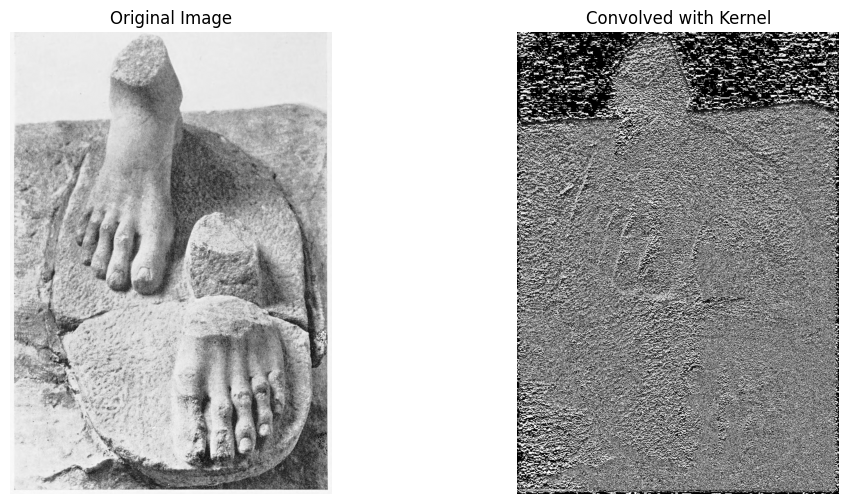

In [14]:
from scipy.ndimage import convolve
from PIL import Image

# Load the image as grayscale
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
image = Image.open(img_path).convert('L')
img_array = np.array(image)

# Define the horizontal edge detection kernel
kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

# Convolve the image with the kernel
convolved = convolve(img_array, kernel, mode='reflect')

# Display the original and convolved images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_array, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(convolved, cmap='gray')
ax[1].set_title("Convolved with Kernel")
ax[1].axis('off')
plt.show()

This tiny image blurs all images:

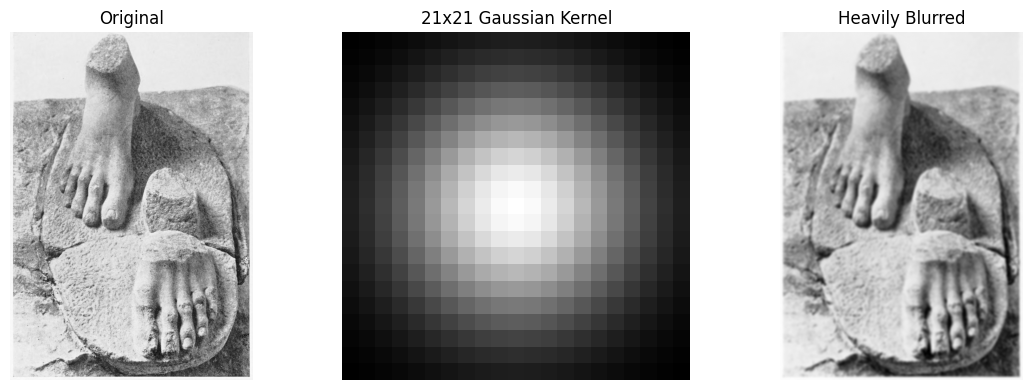

In [15]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

def gaussian_kernel(size=21, sigma=5):
    ax = np.linspace(-(size-1)//2, (size-1)//2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(21, 5)
conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title("21x21 Gaussian Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Heavily Blurred"); ax[2].axis('off')
plt.tight_layout(); plt.show()

This does nothing:

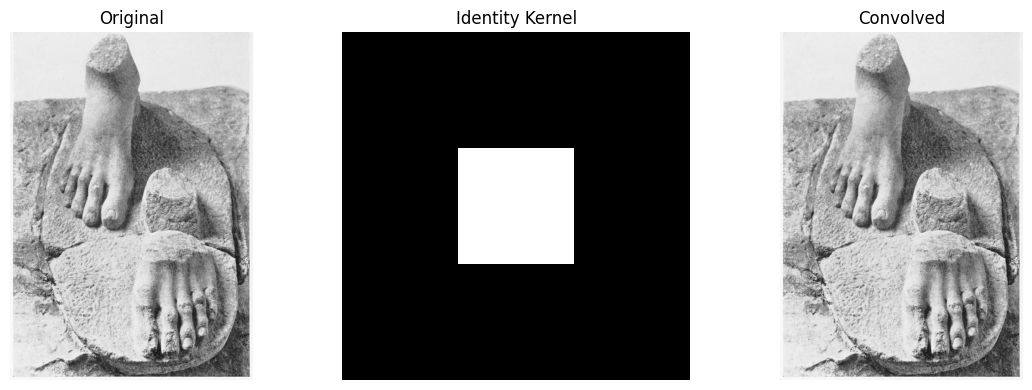

In [16]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

# Identity kernel (3x3)
kernel = np.zeros((3, 3))
kernel[1, 1] = 1

conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray', vmin=0, vmax=1); ax[1].set_title("Identity Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Convolved"); ax[2].axis('off')
plt.tight_layout(); plt.show()

This sharpens images

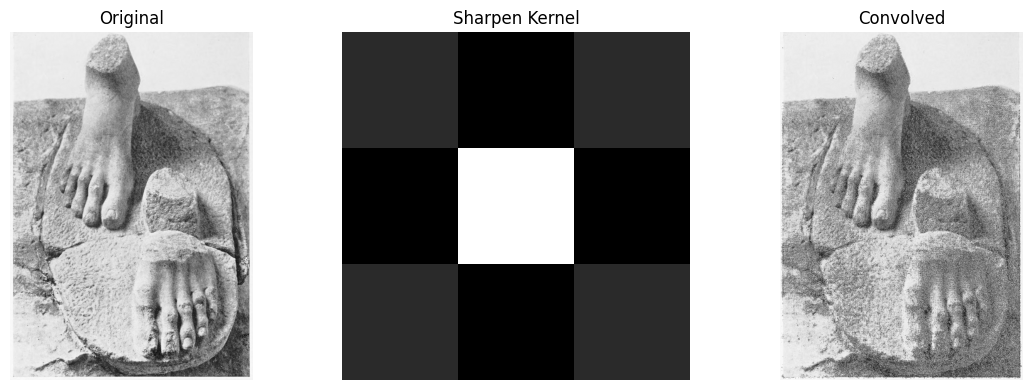

In [17]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

# Sharpen kernel
kernel = np.array([[ 0, -1,  0],
                   [-1,  5, -1],
                   [ 0, -1,  0]])

conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title("Sharpen Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Convolved"); ax[2].axis('off')
plt.tight_layout(); plt.show()

This embosses images:

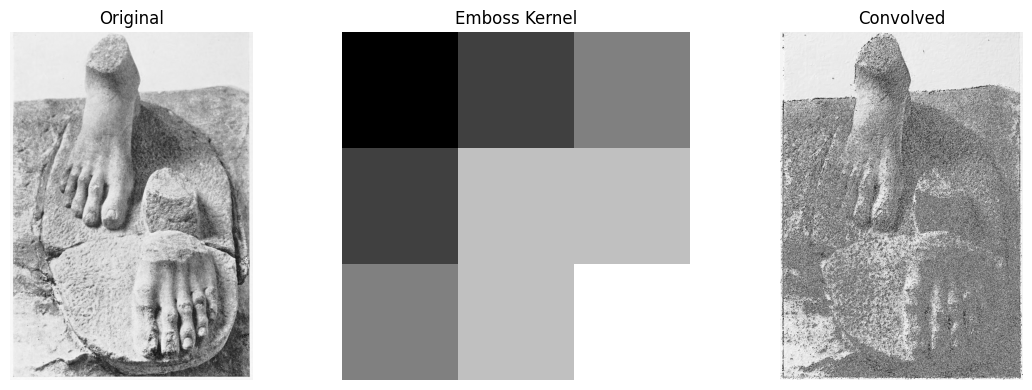

In [18]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

# Emboss kernel
kernel = np.array([[-2, -1, 0],
                   [-1,  1, 1],
                   [ 0,  1, 2]])

conv = convolve(img, kernel)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(kernel, cmap='gray'); ax[1].set_title("Emboss Kernel"); ax[1].axis('off')
ax[2].imshow(conv, cmap='gray'); ax[2].set_title("Convolved"); ax[2].axis('off')
plt.tight_layout(); plt.show()

This detects edge:

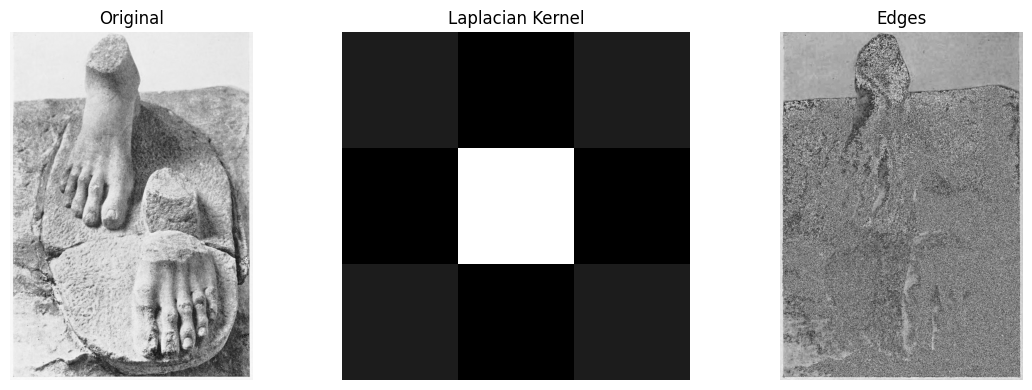

In [19]:
img_path = "../data/richter_kouroi_filtered_photos/page300_img01_photo8.jpg"
img = np.array(Image.open(img_path).convert('L'))

laplacian = np.array([[0,-1,0],[-1,8,-1],[0,-1,0]])
edge = convolve(img, laplacian)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off'
)
ax[1].imshow(laplacian, cmap='gray'); ax[1].set_title("Laplacian Kernel"); ax[1].axis('off')
ax[2].imshow(edge, cmap='gray'); ax[2].set_title("Edges"); ax[2].axis('off')
plt.tight_layout(); plt.show()

These tiny images or "kernels" or "filters" were discovered by people over many years. Im machine learning, we discover or learn these filters that may be useful directly from data.

A model used to clsssify images might learn (on its own) filters that highlight things the model needs like edges and lines. 

The models also learn filters that detect heads, eyes, ears and other abstract concepts. 

### 4. Image Embedding Using ConvNeXt V2

#### 4.1 CNN and Models See Images

In [20]:
# Read in the pre-trained ConvNeXtV2 model
from transformers import AutoImageProcessor
from transformers import ConvNextV2Model
from torchvision.models import convnext_base
import torch
from tqdm.notebook import tqdm

# Load the pre-trained ConvNeXtV2 model and image processor
processor = AutoImageProcessor.from_pretrained("facebook/convnextv2-base-22k-224") 
attention_model = convnext_base(pretrained=True)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-t

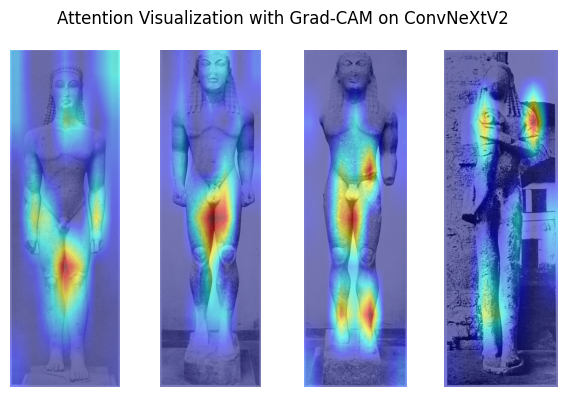

In [21]:
# Load the Grad-CAM library for attention visualization
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

target_layers = [attention_model.features[-1]]
cam = GradCAM(model=attention_model, target_layers=target_layers)

n_cols = 4
fig, axes = plt.subplots(1, n_cols, figsize=(1.5 * n_cols, 4))
for i, rgb_orig in enumerate(images[:n_cols]):
    # rgb_orig: float array H×W×3 in [0,1]
    rgb_orig = rgb_orig.astype(np.float32) / 255.0
    h, w, _ = rgb_orig.shape
    
    # Convert to PIL for resizing + normalization
    img_pil = Image.fromarray((rgb_orig * 255).astype(np.uint8))
    input_tensor = transform(img_pil).unsqueeze(0)
    
    # Compute CAM (grayscale at 224×224)
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=[ClassifierOutputTarget(0)])[0]
    
    # Upsample back to original size
    grayscale_cam_orig = cv2.resize(grayscale_cam, (w, h),
                                    interpolation=cv2.INTER_LINEAR)
    
    # Overlay heatmap on the original image
    visualization = show_cam_on_image(rgb_orig, grayscale_cam_orig, use_rgb=True)
    
    # Display
    ax = axes[i]
    ax.imshow(visualization)
    ax.axis("off")

plt.suptitle("Attention Visualization with Grad-CAM on ConvNeXtV2")
plt.tight_layout()
plt.show()

#### 4.2 Creating Image Embeddings

In [22]:
model = ConvNextV2Model.from_pretrained("facebook/convnextv2-base-22k-224")

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

ConvNextV2Model(
  (embeddings): ConvNextV2Embeddings(
    (patch_embeddings): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextV2LayerNorm()
  )
  (encoder): ConvNextV2Encoder(
    (stages): ModuleList(
      (0): ConvNextV2Stage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextV2Layer(
            (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (layernorm): ConvNextV2LayerNorm()
            (pwconv1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELUActivation()
            (grn): ConvNextV2GRN()
            (pwconv2): Linear(in_features=512, out_features=128, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextV2Layer(
            (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (layernorm): ConvNextV2LayerNorm()
            (pwconv1): Linear(in_featu

In [23]:
batch_size = 16
embeddings = []
valid_filenames = []

image_directory = "../data/richter_kouroi_complete_front_only"

filenames = df['filename'].tolist()

for i in tqdm(range(0, len(filenames), batch_size), desc="Processing Images in Batches"):
    batch_filenames = filenames[i : i + batch_size]
    images = []
    for filename in batch_filenames:
        path = os.path.join(image_directory, filename)
        try:
            img = Image.open(path).convert("RGB")
            images.append(img)
        except FileNotFoundError:
            print(f"Missing: {path}")
        except Exception as e:
            print(f"Error with {filename}: {e}")

    if not images:
        continue

    # Prepare inputs
    inputs = processor(images=images, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    # Forward through feature extractor
    with torch.no_grad():
        outputs = model(pixel_values)   
    # Global average pool
    if isinstance(outputs, torch.Tensor):
        hidden = outputs           
    else:
        hidden = outputs.last_hidden_state  # shape (B, seq_len, C)

    batch_emb = hidden.mean(dim=(2, 3)).cpu().numpy()

    embeddings.extend(batch_emb)   # now embeddings is a list of shape-(C,) arrays
    
embeddings = np.stack(embeddings, axis=0)  # → (N_images, C)

np.save('../data/embeddings/convnextv2_image_embeddings.npy', embeddings)

Processing Images in Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
print(embeddings)

embeddings.shape

[[-0.42546925 -4.1213965  -2.0160944  ... -2.990932    4.874348
  -0.30853513]
 [ 0.5560605  -2.864719   -2.922471   ... -1.7647417   4.883092
  -0.54576814]
 [-1.286525   -1.4737655  -3.7921906  ...  0.15527482  1.6415099
  -1.8216579 ]
 ...
 [-2.3245587  -3.1991029  -3.004583   ... -0.4007322  -0.21882866
   0.59363395]
 [-0.52835923 -4.4333277  -3.7179325  ... -3.0150363   2.0326374
  -1.6606884 ]
 [ 0.31188458 -2.7383518  -3.1720145  ... -3.6925344   3.5139432
   1.2292057 ]]


(62, 1024)

### 5. Analysis of Image Embeddings
#### 5.1 Principal Component Analysis

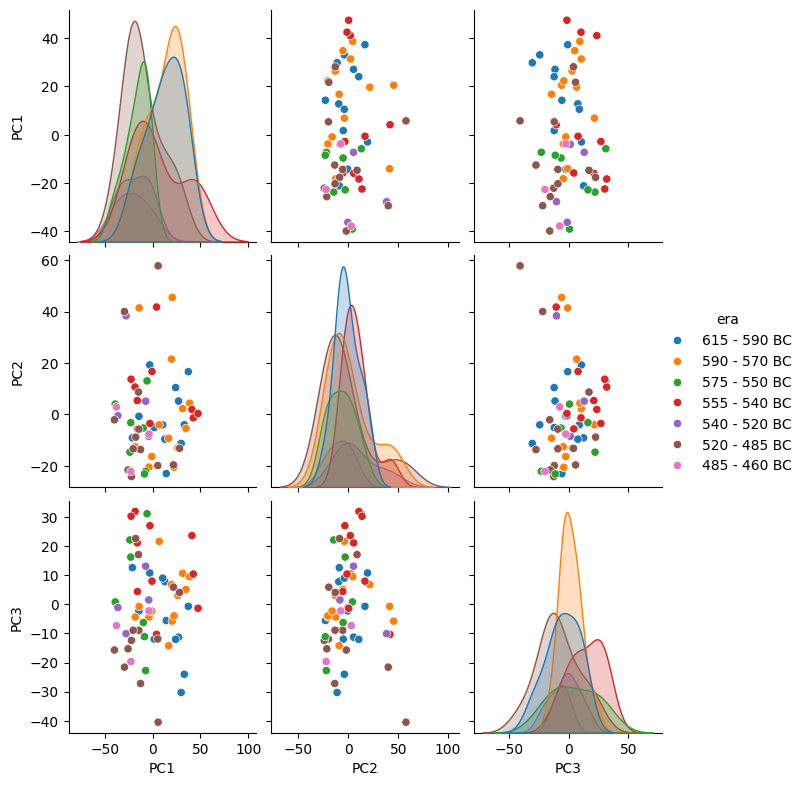

In [25]:
from sklearn.decomposition import PCA
import seaborn as sns

# We can load the embeddings from the saved file
embeddings = np.load('../data/embeddings/convnextv2_image_embeddings.npy')

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(embeddings)

pc_df = pd.DataFrame(
    pca_embeddings[:, :3],
    columns=['PC1','PC2','PC3']
)

# Generate the visualization of PCA embeddings with the era labels
pc_df['era'] = df['era'].values

g = sns.pairplot(pc_df, hue='era', vars=['PC1','PC2','PC3'])
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
plt.show()


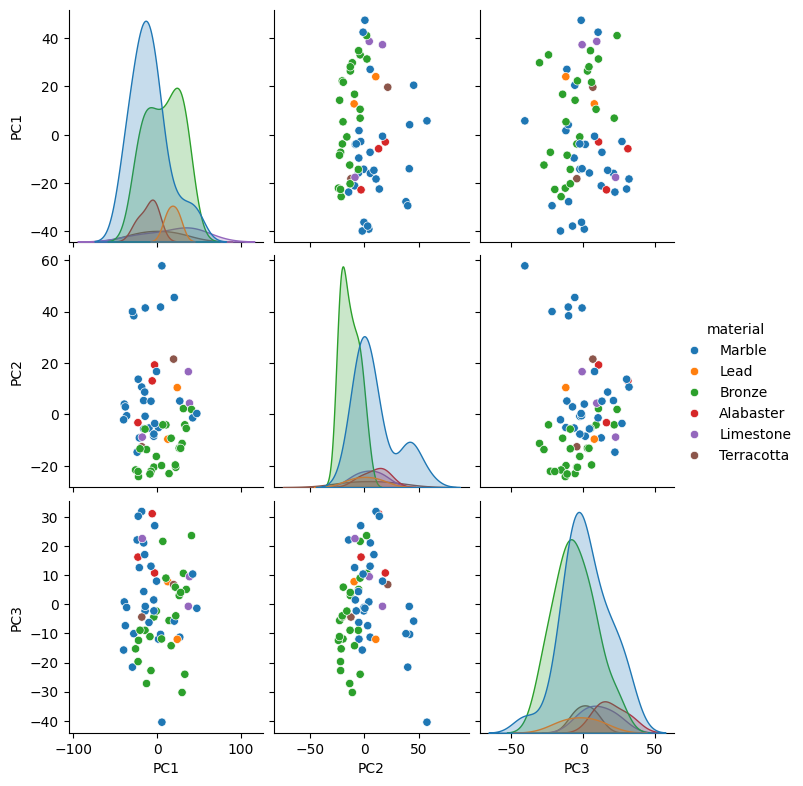

In [26]:
pc_df['material'] = df['material'].values

g = sns.pairplot(pc_df, hue='material', vars=['PC1','PC2','PC3'])
g.fig.set_figwidth(8)
g.fig.set_figheight(8)
plt.show()

#### 5.2 TSNE Visualization

In [27]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, init='pca', method='exact')
tsne_embeddings = tsne.fit_transform(embeddings)

plotly_df = pd.DataFrame({
    'TSNE_Dim1': tsne_embeddings[:, 0],
    'TSNE_Dim2': tsne_embeddings[:, 1],
    'Era': df['era'].tolist(), # Use the 'era' column from your original df
    'Filename': df['filename'].tolist(), # Include the filenames
    'Material': df['material'].tolist() # Include the material column
})

# Plot the t-SNE embeddings colored by Era
fig = px.scatter(
        plotly_df,
        x='TSNE_Dim1',
        y='TSNE_Dim2',
        color='Era',
        hover_data=('Filename',), # Show filename when hovering
        title='Interactive t-SNE of Image Embeddings Colored by Era',
        width=700, height=500
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [28]:
# Plot the t-SNE embeddings colored by material
fig = px.scatter(
        plotly_df,
        x='TSNE_Dim1',
        y='TSNE_Dim2',
        color='Material',
        hover_data=['Filename'], # Show filename when hovering
        title='Interactive t-SNE of Image Embeddings Colored by Material',
        width=700, height=500
    )

fig.show()

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\express\_core.py:1983: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



#### 5.3 K-Means Clustering

### 6. Example: Classification of Kouroi Based on Image Embedding

#### 6.1 Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = embeddings
y1 = df['era'].tolist()
y2 = df['material'].tolist()

y1 = np.array(y1)
y2 = np.array(y2)

In [30]:
# Perform the classification of eras

# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.3, random_state=42, stratify=y1)

# Create a logistic regression model
clf1 = LogisticRegression(max_iter=1000, random_state=42)

clf1.fit(X_train1, y_train1)

y_pred1 = clf1.predict(X_test1)

# Calculate classification metrics
classification_report1 = metrics.classification_report(y_test1, y_pred1, zero_division=0)

# Print the classification report 
print("Classification Report for Eras:")
print(classification_report1)

Classification Report for Eras:
              precision    recall  f1-score   support

485 - 460 BC       0.00      0.00      0.00         1
520 - 485 BC       0.40      0.50      0.44         4
540 - 520 BC       0.00      0.00      0.00         1
555 - 540 BC       0.33      0.67      0.44         3
575 - 550 BC       0.00      0.00      0.00         2
590 - 570 BC       0.00      0.00      0.00         4
615 - 590 BC       1.00      0.25      0.40         4

    accuracy                           0.26        19
   macro avg       0.25      0.20      0.18        19
weighted avg       0.35      0.26      0.25        19



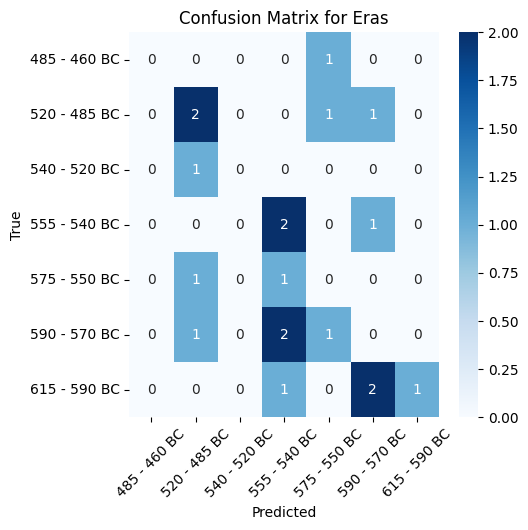

In [31]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test1, y_pred1, labels=np.unique(y1))

plt.figure(figsize=(5, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y1), yticklabels=np.unique(y1))

plt.title('Confusion Matrix for Eras')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.show()

In [32]:
# Perform the classification of materials

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.3, random_state=42, stratify=y2)

# Create a logistic regression model
clf2 = LogisticRegression(max_iter=1000, random_state=42)

clf2.fit(X_train2, y_train2)

y_pred2 = clf2.predict(X_test2)

# Calculate classification metrics
classification_report2 = metrics.classification_report(y_test2, y_pred2, zero_division=0)

# Print the classification report
print("Classification Report for Materials:")
print(classification_report2)

Classification Report for Materials:
              precision    recall  f1-score   support

   Alabaster       0.00      0.00      0.00         1
      Bronze       0.78      1.00      0.88         7
        Lead       0.00      0.00      0.00         1
   Limestone       0.00      0.00      0.00         1
      Marble       0.80      1.00      0.89         8
  Terracotta       0.00      0.00      0.00         1

    accuracy                           0.79        19
   macro avg       0.26      0.33      0.29        19
weighted avg       0.62      0.79      0.70        19



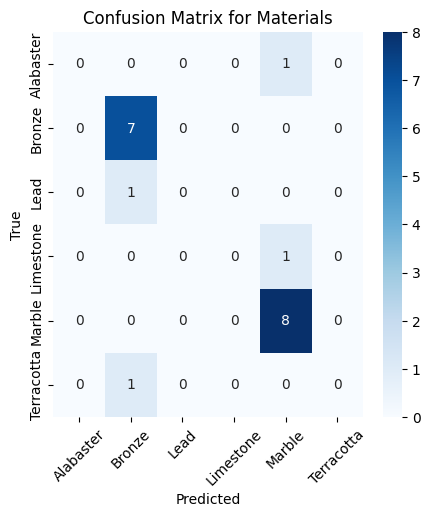

In [33]:
# Plot the confusion matrix
cm2 = confusion_matrix(y_test2, y_pred2, labels=np.unique(y2))

plt.figure(figsize=(5, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y2), yticklabels=np.unique(y2))

plt.title('Confusion Matrix for Materials')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.show()

#### 6.2 CNN Classification of Materials

In [34]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Map the materials to integers

MAT2IDX = {
    'Marble': 0,
    'Bronze': 1,
    'Lead': 2,
    'Alabaster': 3,
    'Limestone': 4,
    'Terracotta': 5,
}

In [35]:
# Create a custom dataset class for the Kouroi dataset
class KouroiDataset(Dataset):
    def __init__(self, img_dir, processor, mat2idx):
        self.df = df
        self.img_dir = image_directory
        self.processor = processor
        self.mat2idx = MAT2IDX

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row.filename)).convert("RGB")
        # turn to model inputs
        inputs = self.processor(images=img, return_tensors="pt")
        # remove batch dim
        for k,v in inputs.items():
            inputs[k] = v.squeeze(0)
        label = self.mat2idx[row.material]
        return inputs, label

In [36]:
# Initialize the dataset and dataloader
dataset = KouroiDataset(image_directory, processor, MAT2IDX)
loader  = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [37]:
# Build the model with convnextv2 as the backbone and a linear layer for classification
class Classifier(nn.Module):
    def __init__(self, backbone_name, num_classes):
        super().__init__()
        # Load the ConvNeXtV2 backbone correctly and freeze it
        self.backbone = ConvNextV2Model.from_pretrained(
            backbone_name,
            output_hidden_states=False,
            output_attentions=False
        )
        for p in self.backbone.parameters():
            p.requires_grad = False

        embed_dim = self.backbone.config.hidden_sizes[-1]

        # Build a simple 2-layer MLP head
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )

    def forward(self, pixel_values):
        # Forward through the frozen backbone
        outputs = self.backbone(pixel_values=pixel_values)
        x = outputs.pooler_output

        # Classification head
        logits = self.head(x)
        return logits

# Instantiate and move to device
model = Classifier(
    backbone_name="facebook/convnextv2-base-22k-224",
    num_classes=len(MAT2IDX)
).to(device)

In [38]:
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-4)
epochs = 10  


for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc=f"Epoch {epoch}/{epochs}"):
        inputs, labels = batch
        # move to device
        inputs = {k:v.to(device) for k,v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(**inputs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / len(dataset)
    print(f" Epoch {epoch} avg loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 1 avg loss: 1.6204


Epoch 2/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 2 avg loss: 1.2603


Epoch 3/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 3 avg loss: 1.0542


Epoch 4/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 4 avg loss: 0.9582


Epoch 5/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 5 avg loss: 0.8929


Epoch 6/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 6 avg loss: 0.8288


Epoch 7/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 7 avg loss: 0.7422


Epoch 8/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 8 avg loss: 0.7134


Epoch 9/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 9 avg loss: 0.6337


Epoch 10/10:   0%|          | 0/4 [00:00<?, ?it/s]

 Epoch 10 avg loss: 0.5916


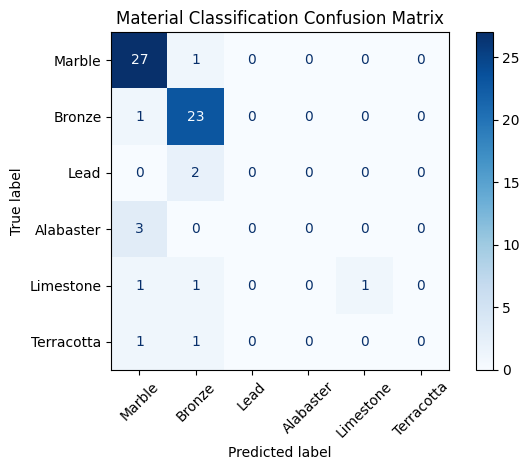

Classification Report for Materials:
              precision    recall  f1-score   support

      Marble       0.82      0.96      0.89        28
      Bronze       0.82      0.96      0.88        24
        Lead       0.00      0.00      0.00         2
   Alabaster       0.00      0.00      0.00         3
   Limestone       1.00      0.33      0.50         3
  Terracotta       0.00      0.00      0.00         2

    accuracy                           0.82        62
   macro avg       0.44      0.38      0.38        62
weighted avg       0.74      0.82      0.77        62



In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run one pass over your data in eval mode
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in loader:
        if inputs is None: continue
        inputs = {k:v.to(device) for k,v in inputs.items()}
        logits = model(**inputs)
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute & plot confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(MAT2IDX.values()))
disp = ConfusionMatrixDisplay(cm, display_labels=list(MAT2IDX.keys()))
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Material Classification Confusion Matrix")
plt.tight_layout()
plt.show()

# Print the classification report
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=list(MAT2IDX.keys()), zero_division=0)
print("Classification Report for Materials:")
print(report)


### 7. (Optional) Computational Formalism? Sentiment Analysis and Content Description Using CLIP

### 8. Conclusion

### Key Takeaways

### Appendix: Data Collection and Preprocessing

### Reference
1. Richter, G. M. A. (1970). *Kouroi: Archaic Greek youths: A study of the development of the Kouros type in Greek sculpture.* Phaidon. Accessed through Internet Archive <https://archive.org/details/kouroiarchaicgre0000rich>.
2. Pinecone. *Embedding Methods for Image Search.* Accessed through Pinecone <https://www.pinecone.io/learn/series/image-search/>.